In [73]:
#!unzip train.zip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
import tqdm
import random
from keras.preprocessing.image import load_img
warnings.filterwarnings('ignore')

Create Dataframe for Input and Output

In [3]:
input_path = []
label = []

for class_name in os.listdir("PetImages"):
    for path in os.listdir("PetImages/"+class_name):
        if class_name == 'Cat':
            label.append(0)
        else:
            label.append(1)
        input_path.append(os.path.join("PetImages", class_name, path))
print(input_path[0], label[0])

PetImages/Dog/dog.975.jpg 1


create the dataframe for processing

In [7]:
df = pd.DataFrame()
df['images'] = input_path
df['label'] = label
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,images,label
0,PetImages/Dog/dog.1674.jpg,1
1,PetImages/Dog/dog.11350.jpg,1
2,PetImages/Cat/cat.8627.jpg,0
3,PetImages/Cat/cat.7153.jpg,0
4,PetImages/Dog/dog.8708.jpg,1


Exploratory Data Analysis

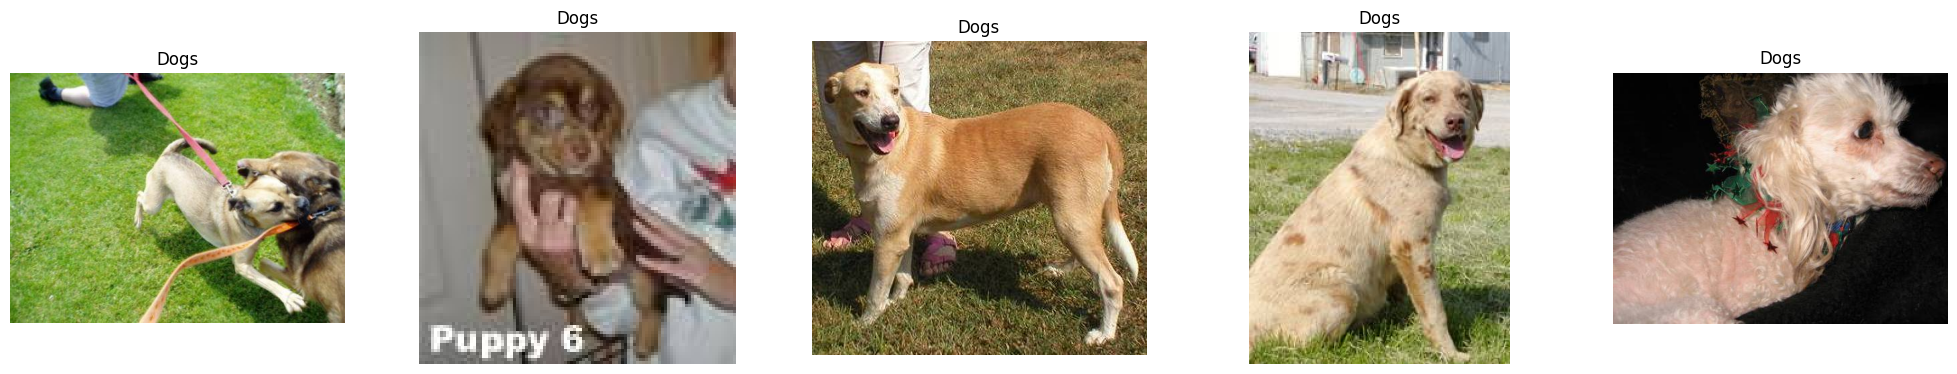

In [15]:
# to display grid of images
plt.figure(figsize=(25,25))
temp = df[df['label']==1]['images']
start = random.randint(0, len(temp))
files = temp[start:start+5]

for index, file in enumerate(files):
    plt.subplot(5,5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title('Dogs')
    plt.axis('off')

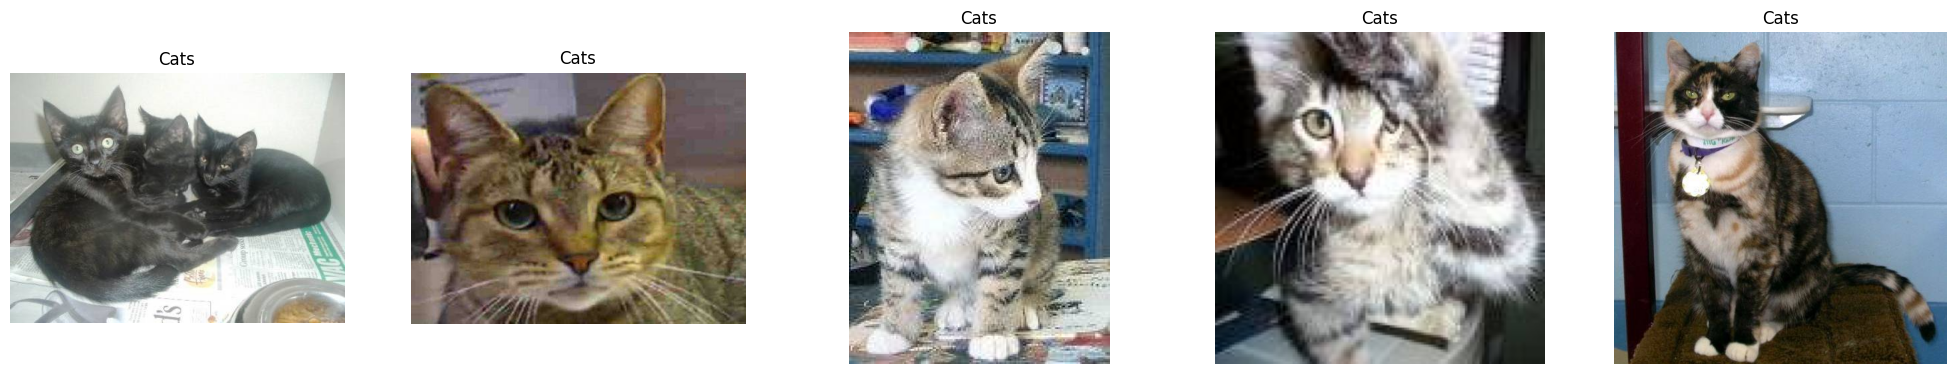

In [16]:
# to display grid of images
plt.figure(figsize=(25,25))
temp = df[df['label']==0]['images']
start = random.randint(0, len(temp))
files = temp[start:start+5]

for index, file in enumerate(files):
    plt.subplot(5,5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title('Cats')
    plt.axis('off')

Create Data Generator for the Images :
Data Generators loads the data from the disk for reading and training the data directly, saving RAM space and avoiding possible overflow that might crash the system.



In [18]:
#Convert the data type of 'label' to string for easier processing
df['label'] = df['label'].astype('str')
df.head()

,images,label
0,PetImages/Dog/dog.1674.jpg,1
1,PetImages/Dog/dog.11350.jpg,1
2,PetImages/Cat/cat.8627.jpg,0
3,PetImages/Cat/cat.7153.jpg,0
4,PetImages/Dog/dog.8708.jpg,1


split the input data


In [23]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#Image Generator rescale and normalizes the images by pixels between 0 and 1 for easier processing.

train_generator = ImageDataGenerator(
    rescale = 1./255,  # normalization of images
    rotation_range = 40, # augmention of images to avoid overfitting
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

val_generator = ImageDataGenerator(rescale = 1./255) #val data non augmented

train_iterator = train_generator.flow_from_dataframe(
    train,x_col='images',
    y_col='label',
    target_size=(128,128),
    batch_size=512, # amount of images to process per iteration (acc to hardware spec)
    class_mode='binary' #cat/dog
)

val_iterator = val_generator.flow_from_dataframe(
    test,x_col='images',
    y_col='label',
    target_size=(128,128),
    batch_size=512,
    class_mode='binary'
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


Model creation

couches model cnn :

1-conv2d-I : regarde l’image et extrait des petits motifs 16 = le nombre de filtres (16 fenêtres différentes). Chacune apprend à détecter quelque chose (par ex : une détecte les lignes verticales, une autre les coins, etc.).

2-maxpool2D-I : C’est une réduction de taille → au lieu de regarder chaque pixel, on garde seulement le plus fort dans chaque carré de 2x2 pixels.Ça sert à réduire la taille de l’image et à garder l’info la plus importante.

3-Conv2D-II : pareil mais avec 32 filtres → donc il détecte des motifs plus complexes (par ex : coins, courbes, textures).

4-maxpool2D-II : Puis on fait encore un MaxPool pour réduire la taille.

5-Conv2D-III : Encore une fois, mais avec 64 filtres → maintenant il peut voir des choses très complexes (par ex : un œil, une oreille, des formes entières).

6-Maxpool2D-III: Encore un pooling pour réduire.

7- Flatten : On aplatit l’image → toutes les infos qu’on a extraites deviennent une longue liste de nombres (tableau 1D)

8-Dense(512, activation='relu')
Ici, on a 512 neurones connectés à toutes les infos précédentes. C’est comme un gros cerveau qui combine tout ce qu’il a appris (petits motifs + formes) pour en déduire quelque chose.

9-La sortie : Dense(1) 1 neurone en sortie → ça donne une valeur entre 0 et 1.



In [28]:
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense

model = Sequential([
            Conv2D(16, (3,3), activation='relu', input_shape=(128,128,3)), #image d’entrée est de 128x128 pixels, et 3 (RGB)
            MaxPool2D((2,2)),
            Conv2D(32, (3,3), activation='relu'),#relu : fonction qui garde seulement les valeurs positives (ça aide le réseau à mieux apprendre).
            MaxPool2D((2,2)),
            Conv2D(64, (3,3), activation='relu'),
            MaxPool2D((2,2)),
            Flatten(),
            Dense(512, activation='relu'),
            Dense(1, activation='sigmoid') #sigmoid : binaire cat/dog
])

compilation of the model

optimizer=’adam’ - automatically adjust the learning rate for the model over the no. of epochs

loss='binary_crossentropy' - loss function for binary outputs

In [29]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,447,137 (24.59 MB)

 Trainable params: 6,447,137 (24.59 MB)

 Non-trainable params: 0 (0.00 B)

train


In [30]:
history = model.fit(train_iterator, epochs=10, validation_data=val_iterator)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 124s 3s/step - accuracy: 0.4994 - loss: 0.8290 - val_accuracy: 0.6096 - val_loss: 0.6662
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - accuracy: 0.6238 - loss: 0.6492 - val_accuracy: 0.6608 - val_loss: 0.6193
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - accuracy: 0.6606 - loss: 0.6107 - val_accuracy: 0.6866 - val_loss: 0.5880
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 110s 3s/step - accuracy: 0.7107 - loss: 0.5645 - val_accuracy: 0.6928 - val_loss: 0.5783
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 110s 3s/step - accuracy: 0.7159 - loss: 0.5524 - val_accuracy: 0.7516 - val_loss: 0.5067
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - accuracy: 0.7563 - loss: 0.5019 - val_accuracy: 0.7436 - val_loss: 0.5150
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 108s 3s/step - accuracy: 0.7591 - loss: 0.4938 - val_accuracy: 0.7776 - val_loss: 0.4727
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 106s 3s/step - accuracy: 0.7771 - loss: 0.4727 - val_accuracy: 0.7678 - v

Metrics visualisation

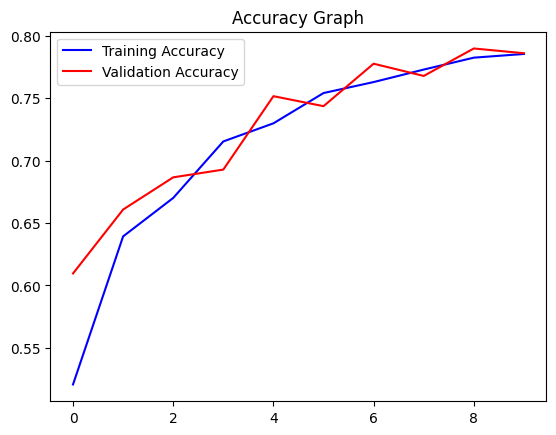

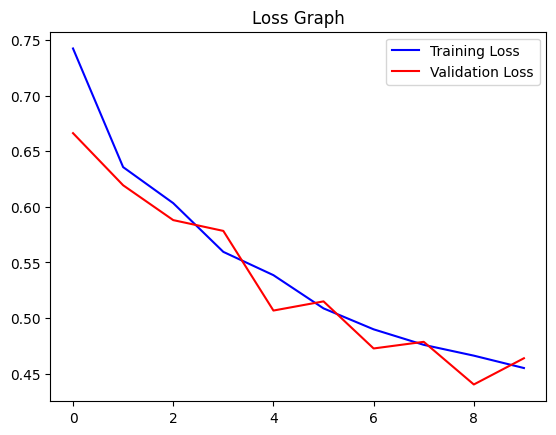

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()




Test


In [72]:
image_path = "25.jpg" # path of the image
img = load_img(image_path, target_size=(128, 128))
img = np.array(img)
img = img / 255.0 # normalize the image
img = img.reshape(1, 128, 128, 3) # reshape for prediction
pred = model.predict(img)
if pred[0] > 0.5:
    label = 'Dog'
else:
    label = 'Cat'
print(label,pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Dog [[0.9948882]]
